# Scale Transform Magnitude for rythimic patterns analysis.

This notebook is based on the methodology proposed in:

- _Holzapfel, A., & Stylianou, Y. (2010). Scale transform in rhythmic similarity of music. IEEE transactions on audio, speech, and language processing, 19(1), 176-185._

The Scale Transform Magnitude (STM) is a descriptor suitable for analyzing rhythmic patterns _without_ relying on beat or downbeat annotations. STM is scale invariant, therefore it is appropriate for comparing pieces with varying tempi.

This notebook serves as a demonstration of the steps involved in computing the STM feature.

- Load short extract of audio
- Compute  mel spectrogram
- Compute the onset strenght signal (OSS) on the mel-spectrogram 
- Compute the autocorrelation of the OSS
- Compute the scale transform magnitude (STM)

| Paper         | Scale Coefs | Window | Hop    | n_mels |
|---------------|-------------|--------|--------|--------|
| Selective     | 400         | 50Hz   | 32ms   | 40     |
| Candomble     | 150         | 64ms   | 20ms   | -      |
| Holzapfel     | 30-250      | 50Hz   | -      | -      |
| Ugo-Marchand  | 60          | 50Hz   | -      | -      |
| U-Marchand2   | 100         | 13-22 Hz | -   | -      |


In [9]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import helpers
import IPython.display as ipd

### Load audio files and decompose spectrograms

The original audio file is a 10-second excerpt from the Malian Jembe dataset (Polak, R., Tarsitani, S., & Clayton, M. (2018). IEMP Malian jembe. Open Science Framework.Polak, R., Tarsitani, S., & Clayton, M. (2018). IEMP Malian jembe. Open Science Framework.).

In [10]:
# path to audio file
audio_file = "clip-MJ_Maraka_1_J1.wav"
# the scaled up version has been obtained using audacity to change the tempo of 15%
audio_file_scaled = "clip-MJ_Maraka_1_J1-scaled-up.wav"

y, sr = librosa.load(audio_file, sr=8000)
y, index = librosa.effects.trim(y)

ipd.display(ipd.Audio(y, rate=sr))

original version


The input signal has been resampled to 8k Hz. 

[Text(0.5, 1.0, 'Power Log Mel Spectrogram')]

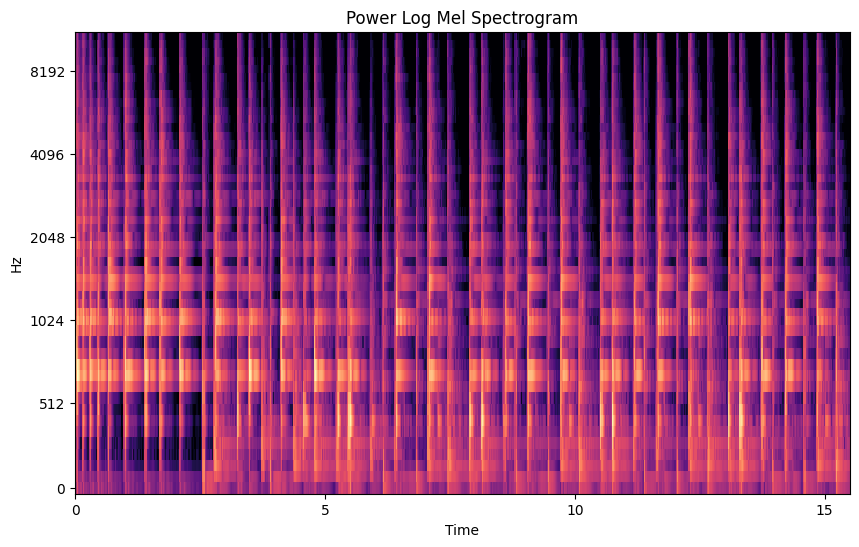

In [11]:
window_size = 256  
hop_size = 128
n_mels = 50

mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, win_length=window_size, hop_length=hop_size)

# # Log-power spectrogram, used as input for the onset strenght signal function
mel = librosa.power_to_db(mel, ref=np.max)

fig, ax = plt.subplots(figsize=(10, 6)) 
img = librosa.display.specshow(mel, y_axis="mel", x_axis="time", ax=ax)
ax.set(title="Power Log Mel Spectrogram")

### Compute Onset Strenght Signal (OSS)

[Text(0.5, 0, 'Time (frames)'), Text(0.5, 1.0, 'Onset strength signal (OSS)')]

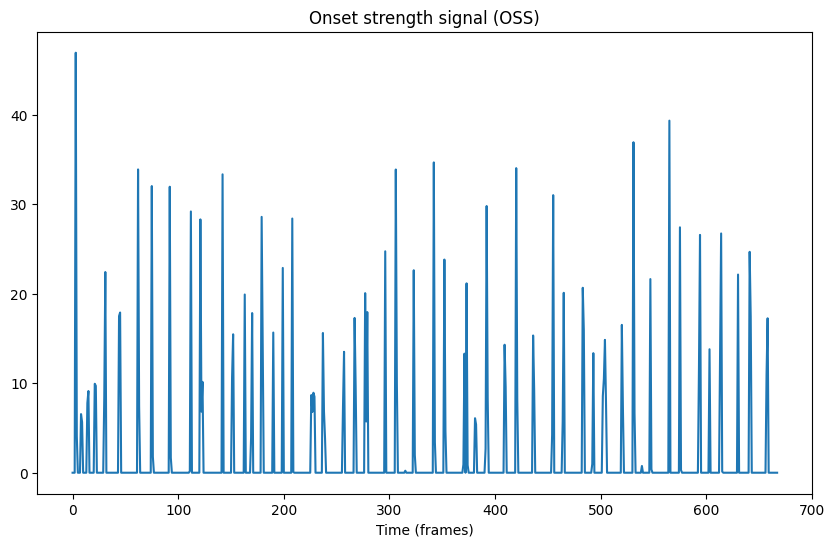

In [12]:
# oss = librosa.onset.onset_strength(y=y, sr=sr, n_mels=50, win_length=window_size, hop_length=hop_size,aggregate=np.median, detrend=True)
# oss_scaled = librosa.onset.onset_strength(y=y_scaled, sr=sr, n_mels=50, win_length=window_size, hop_length=hop_size, aggregate=np.median, detrend=True)

oss = librosa.onset.onset_strength(S=mel, sr=sr, lag=1, max_size=1, aggregate=np.median)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(oss)
ax.set(xlabel="Time (frames)", title="Onset strength signal (OSS)")

From the graph above, it can be observed that the two signals exhibits a different onset strength signal (OSS). That is because the tempo of the second signal is scaled up by a factor of 15%.

In the following section, we demonstrate the invariance of the Scale Transform Magnitude (STM) to tempo changes. In other words, despite the tempo alteration, the magnitudes of the two signals remain the same.

Before proceeding with the computation of the scale transform, it's necessary to calculate the autocorrelation of the OSS. This step is crucial to overcome the fact that the STM is **not** shift-invariant.

### Compute Autocorrelation & Scale Transform Magnitude

Open questions:
- Max size for autocorrelation? Currently up to 8 seconds.
- Number of coefficients to keep from STM? [30-400]


(200,)


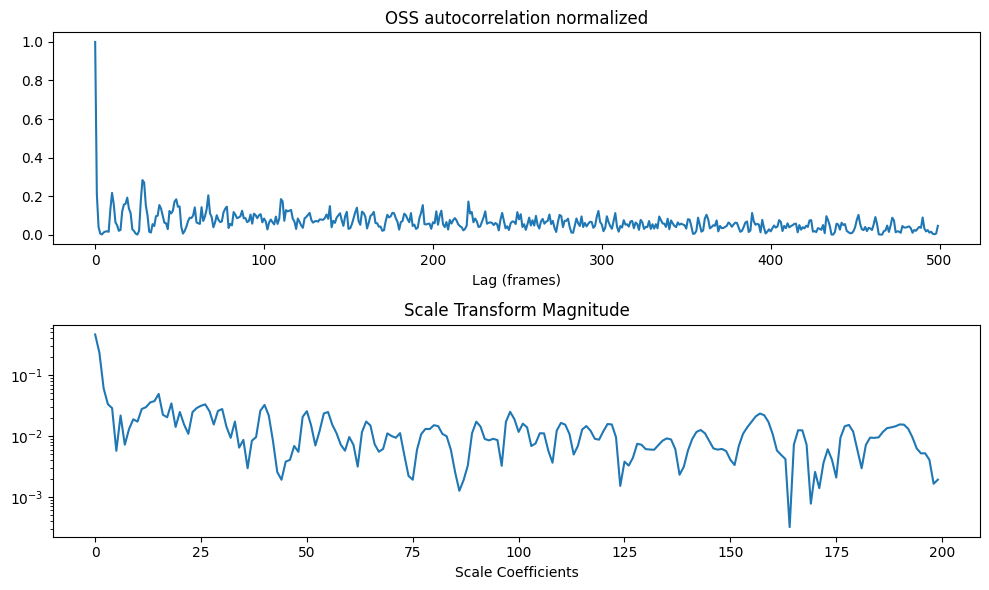

In [13]:
# auto correlation up to 8 seconds
oss_ac = librosa.autocorrelate(oss, max_size=8 * sr // hop_size)

# Normalization
oss_ac = librosa.util.normalize(oss_ac, norm=np.inf)

# scale transform magnitude
fmt_n = 400
stm = np.abs(librosa.fmt(oss_ac, n_fmt=fmt_n))[:200]

print(stm.shape)

fig, ax = plt.subplots(nrows=2, figsize=(10, 6))

ax[0].plot(oss_ac)

ax[0].set(xlabel="Lag (frames)", title="OSS autocorrelation normalized")

ax[1].semilogy(np.abs(stm))

ax[1].set(xlabel="Scale Coefficients", title="Scale Transform Magnitude")

plt.tight_layout()